# Armis Data Hack Challenge - Solution

### Imports and Consts

In [27]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
DEVICES_PATH = "all_devices.csv"
CHUNK_PATH = "chunk-" # + '1','2',...,'23' + '.csv'
submission = pd.DataFrame(columns=["network_id", "device_id", "confidence"])
rng = np.random.RandomState(42)

### Feature exploration

In [28]:
chunk1 = pd.read_csv(CHUNK_PATH + '1' + '.csv',index_col=[0]) #index_col=[0] to use 1st col as index
cols = chunk1.columns
chunk1 = chunk1.groupby(['network_id','device_id']).aggregate({'host': 'nunique','packets_count': 'sum',
                                                           'inbound_bytes_count': 'sum','outbound_bytes_count': 'sum',
                                                           'port_dst' : 'nunique',  'service_device_id' : 'nunique',
                                                           'packets_count' : 'sum','packet_loss' : 'sum',
                                                           'retransmit_count': 'sum', 'latency' : 'sum','session_count' : 'sum'})


In [29]:
chunk1['in_out_ratio'] = chunk1.inbound_bytes_count / chunk1.packets_count
chunk1.corr()

,host,packets_count,inbound_bytes_count,outbound_bytes_count,port_dst,service_device_id,packet_loss,retransmit_count,latency,session_count,in_out_ratio
host,1.000000,0.085799,0.084590,0.042827,0.410814,0.321097,0.305871,0.115598,0.187792,0.270361,0.354875
packets_count,0.085799,1.000000,0.918514,0.469075,0.024798,0.031344,0.081043,0.474288,0.029828,0.121676,0.093877
inbound_bytes_count,0.084590,0.918514,1.000000,0.237986,0.018835,0.012810,0.046772,0.702768,0.032704,0.080699,0.117614
outbound_bytes_count,0.042827,0.469075,0.237986,1.000000,0.019770,0.009590,0.054275,0.080348,0.012776,0.063321,0.011007
port_dst,0.410814,0.024798,0.018835,0.019770,1.000000,0.706851,0.189015,0.047705,0.031743,0.283304,0.138483
service_device_id,0.321097,0.031344,0.012810,0.009590,0.706851,1.000000,0.359859,0.064250,-0.017769,0.554915,0.070571
packet_loss,0.305871,0.081043,0.046772,0.054275,0.189015,0.359859,1.000000,0.255588,0.066027,0.765788,0.042255
retransmit_count,0.115598,0.474288,0.702768,0.080348,0.047705,0.064250,0.255588,1.000000,0.031722,0.164189,0.050068
latency,0.187792,0.029828,0.032704,0.012776,0.031743,-0.017769,0.066027,0.031722,1.000000,0.029543,0.082559
session_count,0.270361,0.121676,0.080699,0.063321,0.283304,0.554915,0.765788,0.164189,0.029543,1.000000,0.011099


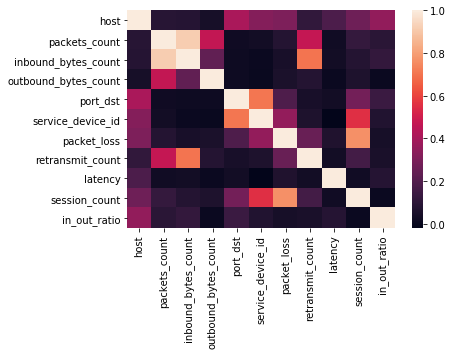

In [30]:
import seaborn as sns
corr = chunk1.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

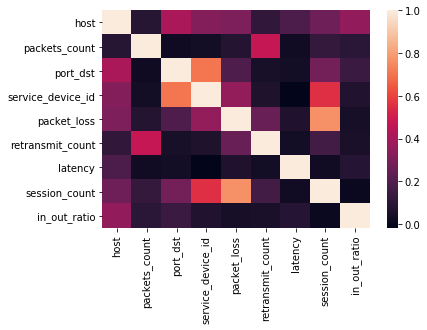

In [31]:
chunk1.drop(['inbound_bytes_count', 'outbound_bytes_count'], axis=1, inplace=True) #drop linear correlated features

corr = chunk1.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
chunk1.reset_index(level=[0,1], inplace=True)

In [32]:
# We use the simple min-max normalization in order to normalize the confidence values to 0-1 range.
# Higher score means that this device is probably more anomalous.
def calc_normalized_decision(decision_function_result):
    decision_function_result = -1 * decision_function_result
    minimum = decision_function_result.min()
    maximum = decision_function_result.max()
    return (decision_function_result - minimum) / (maximum - minimum)

## extract features
- replacing 'inbound_bytes_count', 'outbound_bytes_count' which are highly correlated with 'packet_counts' with 'in_out_ratio'
- this feature can tell if device is sending the requests only for attack proposes.

In [33]:
def extract_features(df_in):
    df = df_in.copy()
    df = df.groupby(['network_id','device_id']).aggregate({'host': 'nunique','packets_count': 'sum',
                                                           'inbound_bytes_count': 'sum','outbound_bytes_count': 'sum',
                                                           'port_dst' : 'nunique',  'service_device_id' : 'nunique',
                                                           'packets_count' : 'sum','packet_loss' : 'sum',
                                                           'retransmit_count': 'sum', 'latency' : 'sum','session_count' : 'sum'})
    df['in_out_ratio'] = df.inbound_bytes_count / df.outbound_bytes_count
    df.drop(['inbound_bytes_count', 'outbound_bytes_count'], axis=1, inplace=True) #drop linear correlated features
    return df

def detect_anomaly(df,esitmator):
    df_out = df.copy()
    esitmator.fit(df_out.values)
    decision_function_result = esitmator.decision_function(df_out.values)
    df_out["confidence"] = calc_normalized_decision(decision_function_result)
    return df_out


In [34]:
#iterating over chunks:
iso = IsolationForest(behaviour='new',random_state=rng,max_samples=0.25,contamination=0.15,n_estimators=250,n_jobs=-1)
cols= pd.read_csv('chunk-1.csv',chunksize = 2,index_col=[0]).get_chunk(2).columns

for i in range (1,23):
    chunk_path = CHUNK_PATH + str(i) + '.csv'
    if i == 1:
       mini_chunk_iso = pd.read_csv(chunk_path,index_col=[0])
    else:
        mini_chunk_iso = pd.read_csv(chunk_path,index_col=[0],names=cols,header=None) #index_col=[0] to use 1st col as index, names= we have the header only in the 1st file
        #print("chunk-"+ str(i) + str(mini_chunk.network_id.iloc[0])) which net_id related to chunk
        #print(len(mini_chunk.device_id.unique().tolist())) how many unique devices in each mini_chunk
        
    mini_chunk_iso = extract_features(mini_chunk_iso)
    mini_chunk_iso = detect_anomaly(mini_chunk_iso,iso)
    mini_chunk_iso.drop(['in_out_ratio','host','packets_count','port_dst','service_device_id','packets_count',
                     'packet_loss','retransmit_count', 'latency','session_count'],axis='columns',inplace=True)
    mini_chunk_iso = mini_chunk_iso.groupby(['network_id','device_id']).aggregate({"confidence": "mean"})
    mini_chunk_iso.reset_index(level=[0,1], inplace=True)
    submission = submission.append(mini_chunk_iso)
    submission = submission.groupby(['network_id','device_id']).aggregate({"confidence": "mean"})
    submission.reset_index(level=[0,1], inplace=True)
    total = len(submission.index)
    print("at chunk-" + str(i)+ f' {total:,}')
        

at chunk-1 19,752
at chunk-2 21,856
at chunk-3 24,129
at chunk-4 25,840
at chunk-5 26,964
at chunk-6 27,530
at chunk-7 29,619
at chunk-8 30,245
at chunk-9 31,678
at chunk-10 32,262
at chunk-11 41,256
at chunk-12 46,465
at chunk-13 49,978
at chunk-14 52,949
at chunk-15 57,720
at chunk-16 59,071
at chunk-17 59,676
at chunk-18 59,831
at chunk-19 60,573
at chunk-20 68,777
at chunk-21 71,064
at chunk-22 75,451


In [35]:


print(submission.device_id.unique())
print(submission.info())
print(submission.describe())
print(submission.head())

[     33      35      40 ... 2740803 2741153 2742647]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75451 entries, 0 to 75450
Data columns (total 3 columns):
network_id    75451 non-null int64
device_id     75451 non-null int64
confidence    75451 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.7 MB
None
         network_id     device_id    confidence
count  75451.000000  7.545100e+04  75451.000000
mean       1.064771  3.872705e+05      0.034277
std        1.145056  5.478891e+05      0.062122
min        0.000000  1.300000e+01      0.000000
25%        0.000000  4.196150e+04      0.005182
50%        1.000000  1.610980e+05      0.013954
75%        2.000000  5.020340e+05      0.037990
max        3.000000  2.742647e+06      0.995970
   network_id  device_id  confidence
0           0         33    0.005248
1           0         35    0.744716
2           0         40    0.078492
3           0         41    0.005060
4           0         53    0.005143


# Submissions

In [36]:
arr_to_submit = submission.to_json(orient='values')

from urllib import request
import json

leaderboard_name = "armis"
host = "leaderboard.datahack.org.il"

# Name of the user
submitter = "Data Sniffers"

predictions = json.loads(arr_to_submit)

jsonStr = json.dumps({'submitter': submitter, 'predictions': predictions})
data = jsonStr.encode('utf-8')
req = request.Request(f"https://{host}/{leaderboard_name}/api/",
                      headers={'Content-Type': 'application/json'},
                      data=data)
resp = request.urlopen(req)
print(json.load(resp))

{'member': 'Data Sniffers', 'rank': 8, 'score': 0.8486555135349111}
